In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy
from tqdm import tqdm
import torch

import warnings

def short_formatwarning(msg, category, filename, lineno, line=None):
    return f"{os.path.basename(filename)}:{lineno}: {category.__name__}: {msg}\n"

warnings.formatwarning = short_formatwarning
warnings.filterwarnings("always", category=RuntimeWarning)

from cosmoglint.utils import MyDataset
from cosmoglint.utils.io_utils import normalize, namespace_to_dict
from cosmoglint.model import transformer_nf_model
from cosmoglint.model import generate_with_transformer_nf as generate

from matplotlib.colors import LogNorm

gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")

def plot_running_mean(x, y, window_size, show_diff=False, **kwargs):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    y = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    if not (len(y) > 0):
        print("No data to plot.")
        return None

    if show_diff:
        y -= y.min()
        plt.yscale("log")

    line = plt.plot(x[:len(y)], y, **kwargs)
    return line


def calc_length(x, threshold, ref_param=0, skip_length=1): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    length = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        count = skip_length
        for j in range(skip_length, seq_length):
            count = j
            if x[i,j,ref_param] < threshold:
                break
        length[i] = count
    return length

def calc_ngal_th(x, threshold, ref_param=0): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    ngal = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        if x[i,0,ref_param] > threshold:
            ngal[i] += 1
        for count, j in enumerate(range(1, seq_length)):
            if x[i,j,ref_param] < threshold:
                break
        ngal[i] += count

    return ngal

def my_savefig(fout, tight_layout=True):
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fout, bbox_inches="tight")
    print(f"Saved figure to {fout}")

_param_names = [r"${\rm SFR}$", r"${d}$", r"${v}_r$", r"${v}_\theta$"]
param_names = [r"$\rm SFR \ [M_\odot /yr]$", r"$d\ [{\rm Mpc}/h]$", r"$v_r \ \rm [km/s]$", r"$v_\theta \ \rm [km/s]$"]

param_labels = ["sfr", "d", "vr", "vt"]

base_dir = "../scripts/runs/output_transformer_nf"
        

# Load Model and Plot Loss

opt:  Namespace(gpu_id=0, output_dir='./runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel', seed=12345, data_path=['../dataset/TNG300-1/TNG300-1_33.h5'], indices=None, norm_param_file='../dataset/param_files/norm_params_33.json', global_param_file=None, input_features=['GroupMass'], output_features=['SubhaloSFR', 'SubhaloDist', 'SubhaloVrad', 'SubhaloVtan'], global_features=None, max_length=50, train_ratio=0.9, batch_size=512, num_epochs=200, lr=0.0001, dropout=0.0, sampler_weight_min=0.02, save_freq=20, exclude_ratio=0.5, model_name='transformer1', d_model=128, num_layers=6, num_heads=8, base_dist='normal', num_context=16, hidden_dim=64, num_flows=8, lambda_stop=1, hidden_dim_stop=64, verbose=False, num_features_cond=1, num_features_in=4, num_features_global=0, norm_param_dict={'GroupMass': {'min': 11.0, 'max': 15.0, 'norm': 'log'}, 'SubhaloSFR': {'min': -3.2, 'max': 3.0, 'norm': 'log'}, 'SubhaloStellarMass': {'min': 7.0, 'max': 11.0, 'norm': 'log'}, 

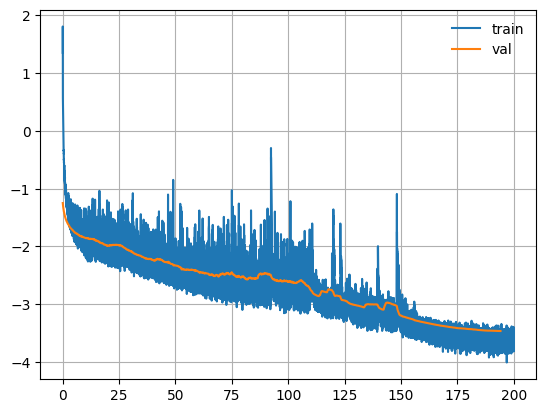

In [2]:
model_dir = "{}/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel".format(base_dir)
#model_dir = "{}/transformer1_33_normal_nc16_nl6_nf8_ep1000_lr1e-5_use_vel".format(base_dir)

output_dir = "{}/figures".format(model_dir)
os.makedirs(output_dir, exist_ok=True)

### plot loss 
loss = np.loadtxt("{}/log.txt".format(model_dir), comments="#")
x = loss[:,0]
plt.figure()
plt.plot(x, loss[:,1], label="train")
loss_val = plot_running_mean(x, loss[:,2], 3000, label="val")
#plt.yscale("log")
#plt.ylim([-4.2, -3.8])
plt.grid()
plt.legend(frameon=False)

### load parameters
with open("{}/args.json".format(model_dir), "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
    opt.norm_param_dict = namespace_to_dict(opt.norm_param_dict)
print("opt: ", opt)

### load model
load_file_option = ""

model, flow = transformer_nf_model(opt)

model.to(device)
model.load_state_dict(torch.load("{}/model{}.pth".format(model_dir, load_file_option)))
model.eval()
print(model)

flow.to(device)
flow.load_state_dict(torch.load("{}/flow{}.pth".format(model_dir, load_file_option)))
flow.eval()
print(flow)

# Generate galaxies for test halo data

In [3]:
### True data ###
data_path = "../dataset/TNG300-1/TNG300-1_33.h5"
ndata = None
#ndata = 10000

dataset_true = MyDataset(data_path, input_features=opt.input_features, output_features=opt.output_features, norm_param_dict=opt.norm_param_dict, max_length=opt.max_length, ndata=ndata, exclude_ratio=opt.exclude_ratio, use_excluded_region=True)
#dataset_true = MyDataset(data_path, input_features=opt.input_features, output_features=opt.output_features, norm_param_dict=opt.norm_param_dict, max_length=opt.max_length, ndata=ndata)

x_true = dataset_true.x
y_true = dataset_true.y_padded

### model output ###
threshold = normalize(1e-3, opt.output_features[0], opt.norm_param_dict)
print(threshold)


count = 0
generated = []
batch_size = opt.batch_size
num_batch = (len(x_true) + batch_size - 1) // batch_size
count = 0
for i in tqdm(range(num_batch)):
    tmp = x_true[count:count+batch_size].to(device)
    with torch.no_grad():
        #gen = generate(model, flow, tmp, stop_predictor=stop_predictor)
        gen = generate(model, flow, tmp, stop_threshold=threshold) #, prob_threshold=1e-5)
    generated.append(gen)

    count += batch_size

generated = torch.cat(generated, dim=0) # (num_halos, seq_length, num_features)

x_true = x_true[:,0].detach().cpu().numpy() # (batch, num_condition) -> (batch,)
y_true = y_true.detach().cpu().numpy()
generated = generated.detach().cpu().numpy()

0it [00:00, ?it/s]

# Loading halo data from ../dataset/TNG300-1/TNG300-1_33.h5
# Using excluded region of size (0.5 * BoxSize)^3


1it [00:03,  3.19s/it]


0.03225806451612906


100%|██████████| 76/76 [00:18<00:00,  4.06it/s]


In [4]:
### calculate length ###
threshold = normalize(1e-3, opt.output_features[0], opt.norm_param_dict)
length_true = calc_length(y_true, threshold)
length_generated = calc_length(generated, threshold)

threshold01 = normalize(0.1, opt.output_features[0], opt.norm_param_dict)
ngal_true_th01 = calc_ngal_th(y_true, threshold=threshold01)
ngal_generated_th01 = calc_ngal_th(generated, threshold=threshold01)

threshold1 = normalize(1., opt.output_features[0], opt.norm_param_dict)
ngal_true_th1 = calc_ngal_th(y_true, threshold=threshold1)
ngal_generated_th1 = calc_ngal_th(generated, threshold=threshold1)

threshold10 = normalize(10, opt.output_features[0], opt.norm_param_dict)
ngal_true_th10 = calc_ngal_th(y_true, threshold=threshold10)
ngal_generated_th10 = calc_ngal_th(generated, threshold=threshold10)

### binning ###
nbins = 20
xbins = np.linspace(0, 1, nbins+1)
xbins_physical_unit_in = normalize(np.repeat(xbins[:,None], len(opt.input_features), axis=1), opt.input_features, opt.norm_param_dict, inverse=True, convert=False)  # (num_bins, num_params)
xbins_physical_unit_out = normalize(np.repeat(xbins[:,None], len(opt.output_features), axis=1), opt.output_features, opt.norm_param_dict, inverse=True, convert=False)

xbin_indices_true = np.digitize(x_true, xbins) - 1 # (num_samples,)
ybin_indices_true = np.digitize(y_true, xbins) - 1 # (num_samples, seq_length, num_params)
ybin_indices_generated = np.digitize(generated, xbins) - 1 # (num_samples, seq_length, num_params)

# Total SFR of halo
mask = np.arange(opt.max_length) < length_true[:,None]
output_masked = normalize(y_true[...,0], opt.output_features[0], opt.norm_param_dict, inverse=True) * mask
y_true_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_true_tot = np.sum(output_masked, axis=1)

mask = np.arange(opt.max_length) < length_generated[:,None]
output_masked = normalize(generated[...,0], opt.output_features[0], opt.norm_param_dict, inverse=True) * mask
y_generated_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_generated_tot = np.sum(output_masked, axis=1)

y_true_sat_tot = np.log10(y_true_sat_tot) # (num_samples,)
y_true_tot = np.log10(y_true_tot) # (num_samples,)
y_generated_sat_tot = np.log10(y_generated_sat_tot) # (num_samples,)
y_generated_tot = np.log10(y_generated_tot) # (num_samples,)

io_utils.py:120: RuntimeWarning: overflow encountered in power
1250084087.py:35: RuntimeWarning: invalid value encountered in multiply
1250084087.py:39: RuntimeWarning: divide by zero encountered in log10
1250084087.py:41: RuntimeWarning: divide by zero encountered in log10


# Histogram

Saved figure to ../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/hist_length.pdf
Saved figure to ../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/hist_length_th.pdf
Saved figure to ../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/hist_length_sfr_bin.png


1515268272.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


Saved figure to ../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/hist_total_sfr.pdf
Saved figure to ../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/hist_central_sfr_logm0.pdf
Saved figure to ../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/hist_central_sfr_logm5.pdf


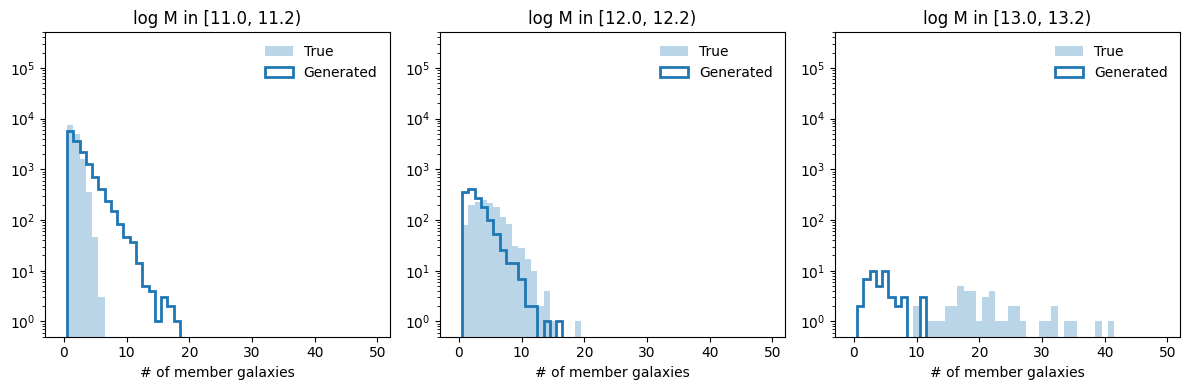

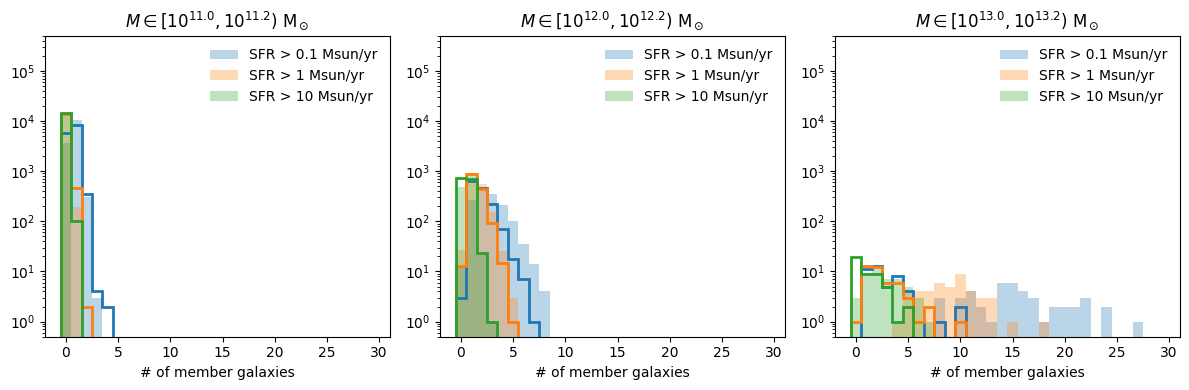

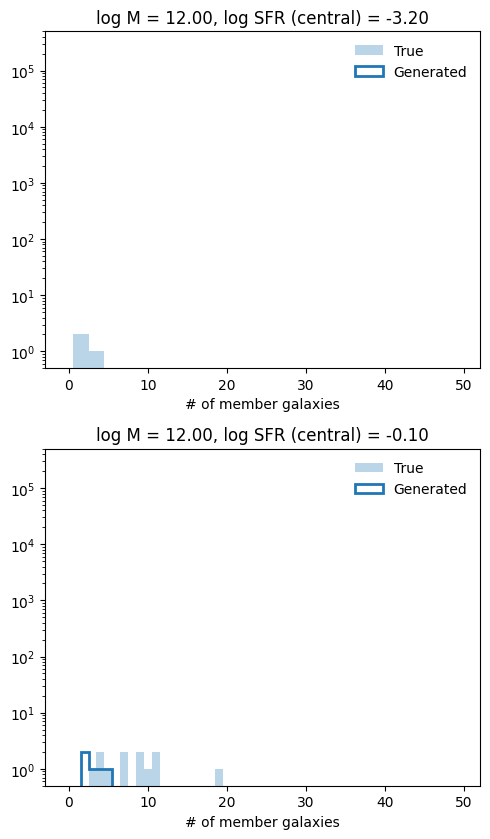

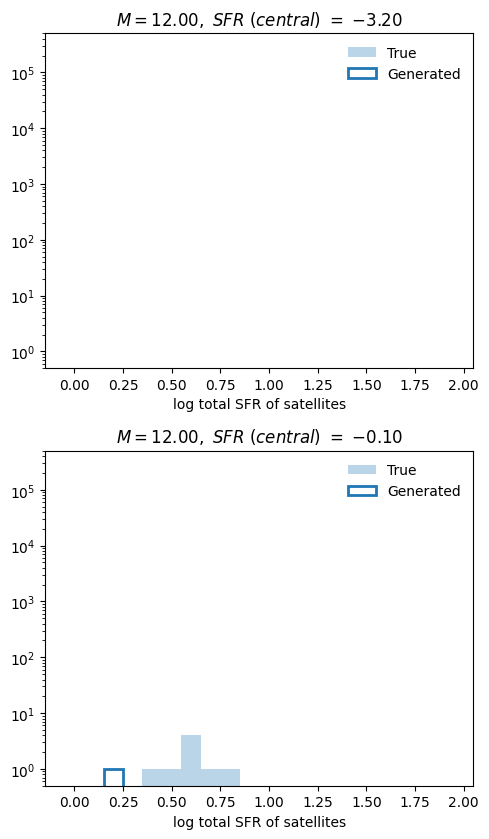

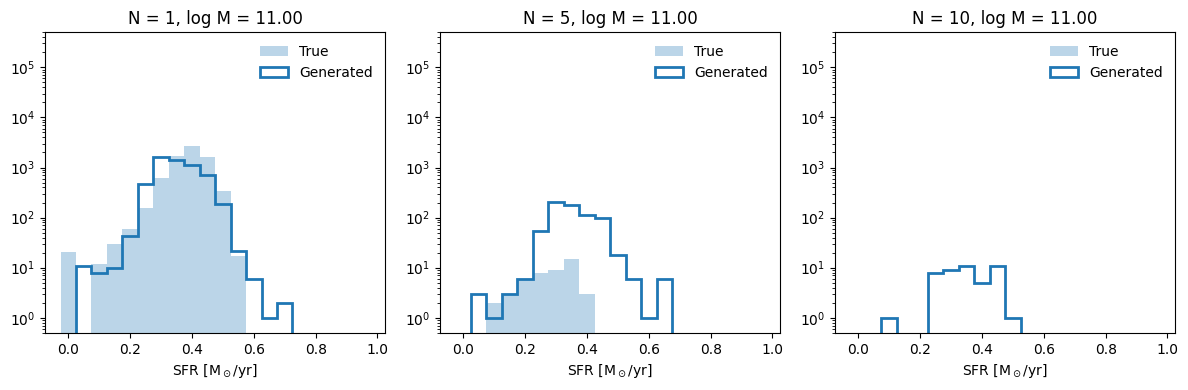

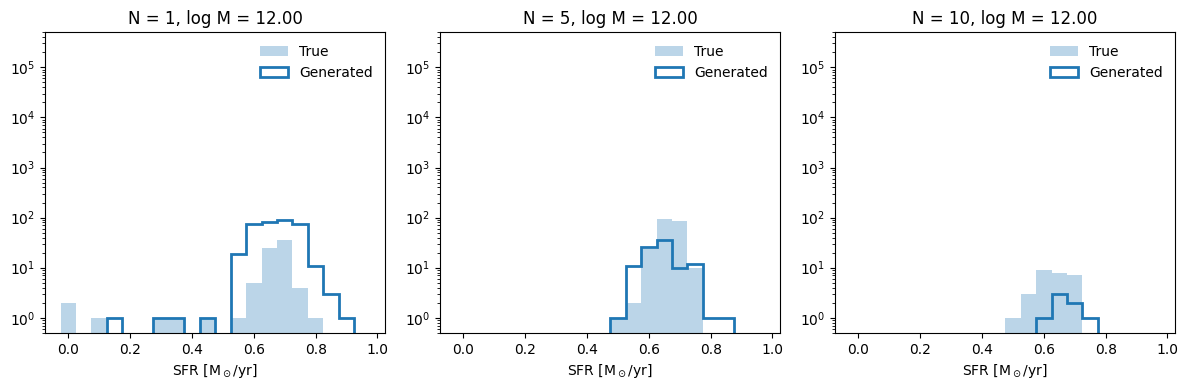

In [5]:
density = False 
#density = True

def show_length_hist(length_list, indices=None, panel_id=(1,1,1), title=None, label_list=["True", "Generated"], xlabel="# of member galaxies", density=density, bin_range=(0,opt.max_length), bins=opt.max_length):

    if indices is None:
        indices = slice(None)
    if not isinstance(indices, (list)):
        indices = [ indices ] * len(length_list)
    if not isinstance(label_list, list):
        label_list = [label_list] * len(length_list)

    plt.subplot(*panel_id)
    plt.title(title)

    for i in range(len(length_list)):
        if i%2 == 0:
            n, bins, patches = plt.hist(length_list[i][indices[i]], range=bin_range, bins=bins, alpha=0.3, density=density, label=label_list[i], align="left")
        else:
            plt.hist(length_list[i][indices[i]], range=bin_range, bins=bins, alpha=1, density=density, label=label_list[i], align="left", histtype="step", color=patches[0].get_facecolor(), linewidth=2)

    plt.yscale("log")
    plt.xlabel(xlabel)
    if density:
        plt.ylim([1e-3, 1.5])
    else:
        plt.ylim([5e-1, 5e5])
    plt.legend(frameon=False)

### Length in bins of log M
list_to_show = [0, 5, 10]
plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i in enumerate(list_to_show):
    indices = np.where(xbin_indices_true == i)[0]
    title = "log M in [{:.1f}, {:.1f})".format(xbins_physical_unit_in[i,0], xbins_physical_unit_in[i+1,0])
    show_length_hist([length_true, length_generated], indices=indices, panel_id=(1,len(list_to_show),count+1), title=title, density=density)

fout = f"{output_dir}/hist_length.pdf"
my_savefig(fout)

### Length with SFR > th in bins of log M
list_to_show = [0, 5, 10]
plt.figure(figsize=(len(list_to_show)*4, 4))
l_list = [ngal_true_th01, ngal_generated_th01, ngal_true_th1, ngal_generated_th1, ngal_true_th10, ngal_generated_th10]
label_list = ["SFR > 0.1 Msun/yr", "", 
              "SFR > 1 Msun/yr", "", 
              "SFR > 10 Msun/yr", ""]
#bin_ranges = [(0, 8), (0, 13), (0, 40)]
bin_ranges = [(0, 30), (0, 30), (0, 30)]
for count, i in enumerate(list_to_show):
    indices = np.where(xbin_indices_true == i)[0]
    title = r"$M \in [10^{%.1f}, 10^{%.1f})\ \rm M_\odot$" % (xbins_physical_unit_in[i,0], xbins_physical_unit_in[i+1,0])

    show_length_hist(l_list, indices=indices, panel_id=(1,len(list_to_show),count+1), title=title, label_list=label_list, density=density, bin_range=bin_ranges[count], bins=bin_ranges[count][1])
fout = f"{output_dir}/hist_length_th.pdf"
my_savefig(fout)


### length in bins in (log M, log SFR)
list_to_show = [5]
y_list_to_show = [0, 10]
plt.figure(figsize=(len(list_to_show)*5, len(y_list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (xbin_indices_true == i)
    for j in y_list_to_show:
        indices = [
            np.where((ybin_indices_true[:,0,0] == j) & base_mask )[0],
            np.where((ybin_indices_generated[:,0,0] == j) & base_mask)[0]
        ]
        title = "log M = {:.2f}, log SFR (central) = {:.2f}".format(xbins_physical_unit_in[i,0], xbins_physical_unit_out[j,0])
        show_length_hist([length_true, length_generated], indices=indices, panel_id=(len(y_list_to_show),len(list_to_show),count+1), title=title, density=density)        
        count += 1

fout = f"{output_dir}/hist_length_sfr_bin.png"
my_savefig(fout)

### Total satellite SFR in bins in (log M, length)
list_to_show = [5]
y_list_to_show = [0, 10]
plt.figure(figsize=(len(list_to_show)*5, len(y_list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (xbin_indices_true == i)
    for j in y_list_to_show:
        indices = [
            np.where((ybin_indices_true[:,0,0] == j) & base_mask )[0],
            np.where((ybin_indices_generated[:,0,0] == j) & base_mask)[0]
        ]
        title = r"$M = {%.2f}, \ SFR\  (central)\  =\ {%.2f}$"%(xbins_physical_unit_in[i,0], xbins_physical_unit_out[j,0])
        show_length_hist([y_true_sat_tot, y_generated_sat_tot], indices=indices, panel_id=(len(y_list_to_show),len(list_to_show),count+1), title=title, density=density, bin_range=(0,2), bins=20, xlabel="log total SFR of satellites")        
        count += 1

fout = f"{output_dir}/hist_total_sfr.pdf"
my_savefig(fout)

### Central SFR in bins in (log M, length)
list_to_show = [0, 5]
length_list_to_show = [1, 5, 10]
for i_logm in list_to_show:
    base_mask = (xbin_indices_true == i_logm)
    for iparam in range(1): # only for the first parameter    
        plt.figure(figsize=(len(length_list_to_show)*4, 4))
        for count, i in enumerate(length_list_to_show):
            
            plt.subplot(1, len(length_list_to_show), count+1)
            title = "N = {:d}, log M = {:.2f}".format(i, xbins_physical_unit_in[i_logm, 0])
            indices = [
                np.where((length_true == i) & base_mask )[0],
                np.where((length_generated == i) & base_mask)[0]
            ]
            show_length_hist([y_true[:,0,iparam], generated[:,0,iparam]], indices=indices, panel_id=(1,len(length_list_to_show),count+1), title=title, density=density, bin_range=(0,1), bins=20, xlabel=param_names[iparam])   

        fout = f"{output_dir}/hist_central_sfr_logm{i_logm}.pdf" 
        my_savefig(fout)

Saved figure to ../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/logm_x.pdf


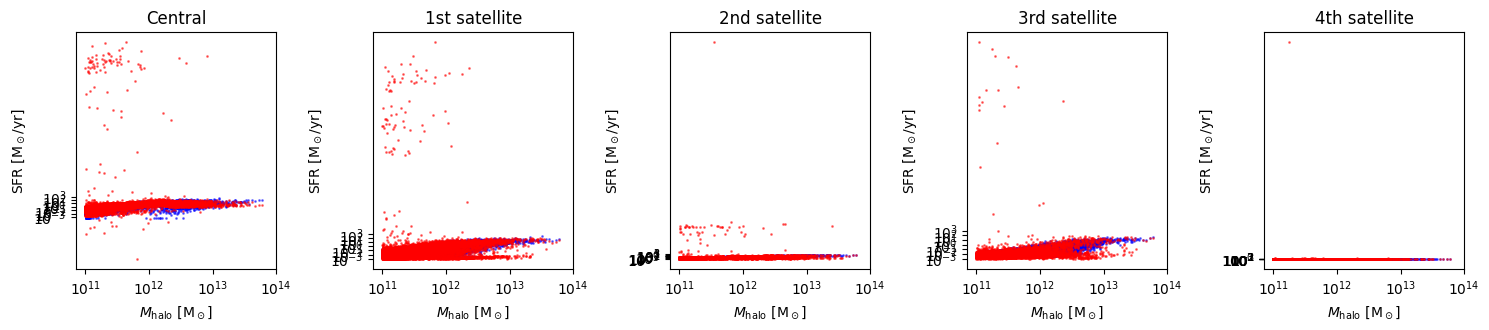

In [6]:

from matplotlib.lines import Line2D

### comparison of M-SFR relations 
show_scatter = True
#show_scatter = False

show_diff = False

colors_black = [(0.8, 0.8, 0.8),(0.4, 0.4, 0.4),"black"]
colors_red = [(0.98, 0.8, 0.8),(0.9, 0.4, 0.4),"red"]

max_length_to_show = 5

def compute_contour_levels(grid_data, sigma_levels=[0.9545, 0.6827, 0.383]): #[0.9973, 0.9545, 0.6827, 0.383]
    grid_data = grid_data / np.sum(grid_data)
    grid_data_sorted = np.sort(grid_data.flatten())[::-1]
    cumsum = np.cumsum(grid_data_sorted)

    levels = [ grid_data_sorted[np.where(cumsum > sigma)[0][0]] for sigma in sigma_levels ]

    return grid_data, levels

plt.figure(figsize=(15, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
target_x = [1e11, 1e12, 1e13, 1e14]
tick_x = normalize( np.array(target_x), opt.input_features, opt.norm_param_dict )

for iparam in range(opt.num_features_in):
    for i in range(max_length_to_show):
        if iparam == 1 and i == 0:
            continue
        if iparam == 2 and i == 0:
            continue

        mask = length_true > i 
        xnow_true = x_true[mask]
        ynow_true = y_true[mask]
        mask = length_generated > i 
        xnow = x_true[mask]
        ynow = generated[mask]

        plt.subplot(4,5,i+1 + iparam * max_length_to_show) 
        if iparam == 0:
            if i == 0:
                plt.title("Central")
            elif i == 1:
                plt.title("1st satellite")
            elif i == 2:
                plt.title("2nd satellite")
            elif i == 3:
                plt.title("3rd satellite")
            else:
                plt.title("{:d}th satellite".format(i))  

        handle_list = []
        if show_scatter:
            plt.scatter(xnow_true, ynow_true[:,i,iparam], s=1, color="blue", alpha=0.5)
            plt.scatter(xnow, ynow[:,i,iparam], s=1, color="red", alpha=0.5)
        else:
            hist_range = [[0,1],[threshold,1]]
            extent = [0,1,threshold,1]

            hist = np.histogram2d(xnow_true, ynow_true[:,i,iparam], bins=20, range=hist_range)
            grid_data, levels = compute_contour_levels(hist[0])
            plt.contour(grid_data.T, extent=extent, colors=colors_red, levels=levels)
            handle_list.append(plt.Line2D([0], [0], color=colors_red[-1], lw=2, label="True"))
            
            hist = np.histogram2d(xnow, ynow[:,i,iparam], bins=20, range=hist_range)
            grid_data, levels = compute_contour_levels(hist[0])
            plt.contour(grid_data.T, extent=extent, colors=colors_black, levels=levels)
            handle_list.append(plt.Line2D([0], [0], color=colors_black[-1], lw=2, label="Generated"))

        if iparam == 0:
            target_y = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
        elif iparam == 1:
            target_y = [1e-2, 1e-1, 1]
        elif iparam == 2:
            target_y = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
        elif iparam == 3:
            target_y = [1e-1, 1, 10, 100, 1000]

        if iparam == 2:
            tick_y = normalize(np.array(target_y), opt.output_features[iparam], opt.norm_param_dict)
        else:
            tick_y = normalize(np.array(target_y), opt.output_features[iparam], opt.norm_param_dict)

        plt.yticks(tick_y, [r"$10^{%.0f}$"%(np.log10(t)) for t in target_y])
        plt.ylabel(param_names[iparam])

        plt.xticks(tick_x, [r"$10^{%.0f}$"%(np.log10(t)) for t in target_x])
        plt.xlabel(r"$M_{\rm halo}\ \rm [M_\odot]$")

        if i == 0 and iparam == 0:
            plt.legend(handles=handle_list, loc="lower right", frameon=False)

    if show_scatter:
        break

fout = f"{output_dir}/logm_x.pdf"
my_savefig(fout)

# TARP Test

100%|██████████| 38746/38746 [2:32:03<00:00,  4.25it/s]  

output ../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/ecp_Nsim38746_marginal.txt


Text(0, 0.5, 'Expected coverage')

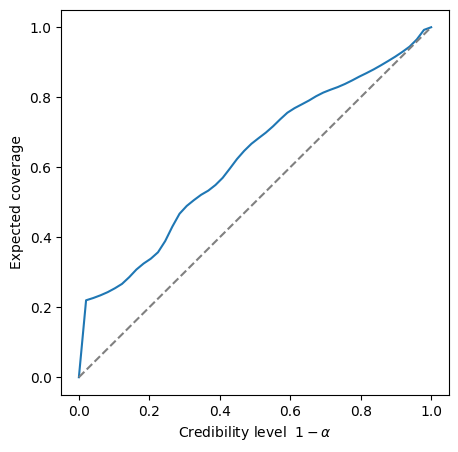

In [8]:
from plot_utils import calc_ecp

def sample_func(x):
    x = x.to(device)
    threshold = normalize(1e-3, opt.output_features[0], opt.norm_param_dict)

    gen = generate(model, flow, tmp, stop_threshold=threshold)
    gen = gen.detach().cpu().numpy()
    seq_length = len(gen[0])   
    length_ij = calc_length(gen, threshold)
    mask = np.arange(seq_length)[None, :] >= length_ij[:, None] 
    gen[mask] = 0    
        
    return gen  

x_true_test = dataset_true.x
y_true_test = dataset_true.y_padded
mask_test = dataset_true.mask

### Select simulation data to use for ECP

Nsim = min(1000, len(x_true_test))
Nsim = len(x_true_test)

indices = np.random.choice(len(x_true_test), Nsim, replace=False)
x_true_test = x_true_test[indices]
y_true_test = y_true_test[indices]
mask_test = mask_test[indices]

### Define reference points

y_ref_name = "rand"
y_ref_name = "input"
y_ref_name = "marginal"

if y_ref_name == "rand":
    y_ref = np.random.rand(*y_true_test.shape)
elif y_ref_name == "input":
    y_ref = x_true_test[:, 0]
    y_ref = y_ref[:, None, None] + 0.5 * torch.rand(*y_true_test.shape) # (Nsim, seq_length, num_params)
    print(y_ref.shape)
else:
    idx = torch.randperm(dataset_true.y_padded.size(0))[:Nsim] 
    y_ref = dataset_true.y_padded[idx]

### Compute ECP

alpha = np.linspace(0, 1, 50)
ecp = calc_ecp(x_true_test, y_true_test, alpha, sample_func, y_ref=y_ref)

fout = "{}/ecp_Nsim{:d}_{}.txt".format(output_dir, Nsim, y_ref_name)
print("output {}".format(fout))
with open(fout, "w") as f:
    for a, e in zip(alpha, ecp):
        f.write("{:.4f} {:.4f}\n".format(a, e))

plt.figure(figsize=(5,5))
plt.plot(1-alpha, ecp)
plt.plot([0,1], [0,1], color="gray", ls="dashed")
plt.xlabel(r"Credibility level $\ 1 - \alpha$")
plt.ylabel("Expected coverage")


# Radial profile

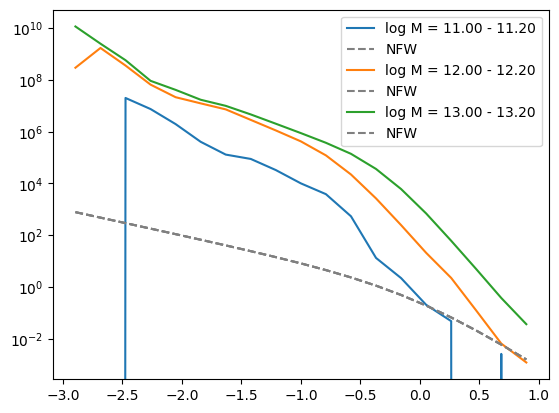

In [16]:
## radial profile
def NFW_profile(logr, log_rs=0, log_rho0=0):
    r = 10**logr 
    rs = 10**log_rs
    rho0 = 10**log_rho0
    return rho0 / (r/rs) / (1 + r/rs)**2
# concentration = rvir / rs = 1e-1 / 1 

nsample = 10000

plt.figure()

list_to_show = [0, 5, 10]
for ibin in list_to_show:
    x_random = torch.rand(nsample).to(device) 
    x_random = x_random * (x_bins[ibin+1] - x_bins[ibin]) + x_bins[ibin]
    generated_test = generate(model, flow, x_random)
    generated_test = generated_test.detach().cpu().numpy()
    length_generated_test = calc_length(generated_test)

    logr_generated_test = generated_test[:,:,1]

    r_bins = np.linspace(0, 1, 20)
    count = 0
    hist_total = np.zeros(len(r_bins)-1)
    for i, (g, l) in enumerate(zip(logr_generated_test, length_generated_test)):
        if l > 1:
            hist = np.histogram(g[1:l], bins=r_bins)
            hist_total += hist[0]
    
    r_bins = normalize(r_bins, opt.output_features[1], opt.norm_param_dict, inverse=True, convert=False)
    logr = 0.5 * (r_bins[1:] + r_bins[:-1])
    nfw_profile = NFW_profile(logr)

    r_bins = 10 ** r_bins
    shell_volume = 4.0 * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3) / 3.0

    hist_total /= shell_volume

    #logr_vir = np.log10( 0.39 ) + 0.3 * ( x_bins_physical_unit_in[ibin, 0] - 12 )
    #logr = logr - logr_vir

    plt.plot(logr, hist_total, label=f"log M = {x_bins_physical_unit_in[ibin, 0]:.2f} - {x_bins_physical_unit_in[ibin+1, 0]:.2f}")
    plt.plot(logr, nfw_profile, ls="--", color="gray", label="NFW")

    plt.yscale("log")

plt.legend()

# Visualize Attention Weights

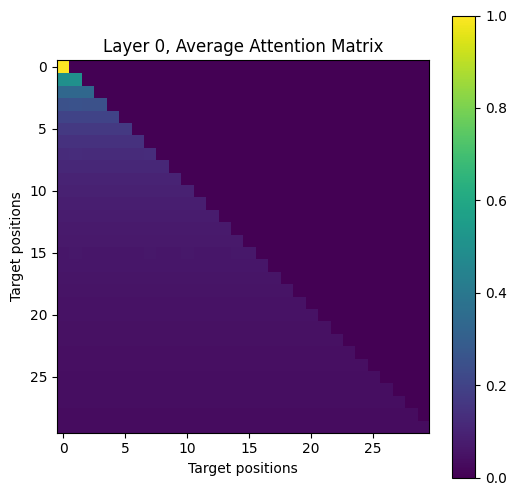

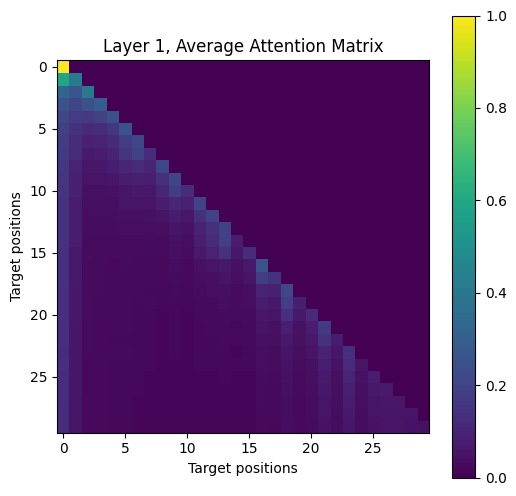

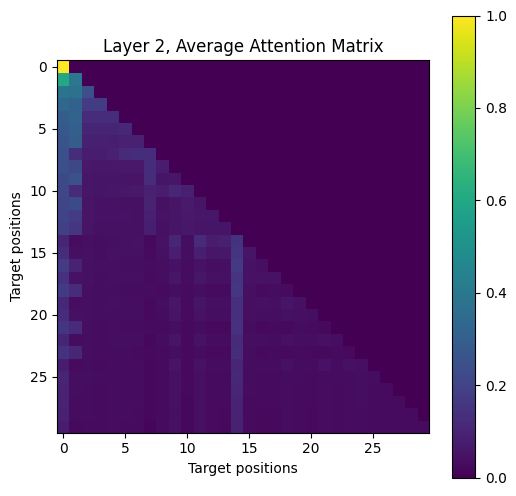

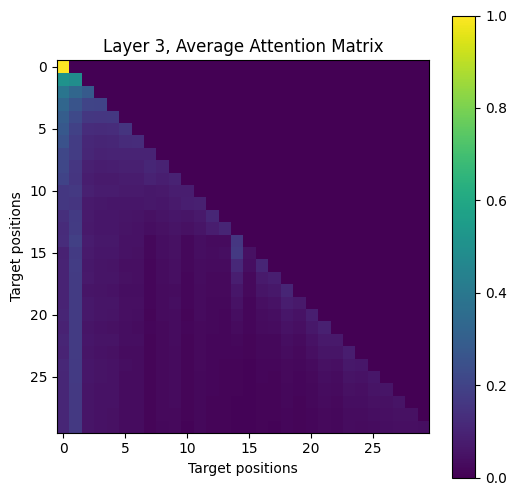

In [ ]:
### Transformer attention visualization

opt_now = copy.deepcopy(opt)
opt_now.model_name = opt.model_name + "_with_attn"
model_now, flow_now = my_transformer_nf_model(opt_now)
model_now.to(device)

model_now.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model_now.eval()

attn_weights = {}

def get_hook(name):
    def hook(module, input, output):
        attn_weights[name] = output[1].detach().cpu() 
    return hook

for i, layer in enumerate(model_now.decoder.layers):
    layer.self_attn.register_forward_hook(get_hook(f'layer_{i}_self_attn'))

con = torch.from_numpy(x_true[0:1]).unsqueeze(-1).to(device)
seq = torch.from_numpy(y_true[0:1,:-1,:]).to(device)

output = model_now(con, seq)

for i in range(opt_now.num_layers):
    attn_matrix = attn_weights[f'layer_{i}_self_attn'][0].numpy()  # (tgt_len, tgt_len)

    plt.figure(figsize=(6, 6))
    plt.imshow(attn_matrix, cmap='viridis')
    plt.colorbar()
    plt.title(f"Layer {i}, Average Attention Matrix")
    plt.xlabel("Target positions")
    plt.ylabel("Target positions")
    plt.show()